<center> <h1> Homework 3 – Improving the Pipeline <h1> </center>
### Goal:
To improve the pipeline based on the feedback from previous assignments, and add a few components based on what we've covered in the past few lectures. More specifically, you need to:

1. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TA. if something critical was pointed out in the feedback, you need to fix it. 

2. Add more classifiers to the pipeline on the code you've written in lab. I’d recommend at least having Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

3. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects.

4. Add additional evaluation metrics that we've covered in class to the pipeline (accuracy, precision at different levels, recall at different levels, F1, area under curve, and precision-recall curves).

5. Create temporal validation function in your pipeline that can create training and test sets over time. You can choose the length of these splits based on analyzing the data. For example, the test sets could be six months long and the training sets could be all the data before each test set.

Analysis:

Once you've set up the improved pipeline, you can use it to solve the problem at https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data 

The goal is to predict, at posting time of a project, if a project will not get fully funded so we can intervene and help them improve the project listing. 

The code should produce a table with results across train test splits over time and performance metrics (baseline, precision and recall at different thresholds 1%, 2%, 5%, 10%, 20%, 30%, 50% and AUC_ROC)

In [265]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm
import statsmodels.api as sm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *

In [266]:
# Supress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [267]:
def load_data(filename, verbose=False):
    df = pd.read_csv(filename, index_col=0)
    if verbose:
        print('Dataset shape:', df.shape)
        print('Dataset columns:', df.columns)
        print('Dataset types:', df.dtypes)
        print('')
    return df

In [268]:
projects = load_data('data/projects.csv')

In [269]:
outcomes = load_data('data/outcomes.csv')

In [270]:
projects['fully_funded'] = outcomes['fully_funded']

In [271]:
projects['date_posted'] = projects['date_posted'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [272]:
df = projects[(projects['date_posted'].dt.year >= 2011) & (projects['date_posted'].dt.year <= 2013)]

In [273]:
df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,t
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,f
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,f
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,f
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,t


## 2. Explore Data

#### Check Correlation

In [274]:
def create_correlation_heatmap(df):
    # compute correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # create figure and plot
    fig = plt.figure(figsize=(len(cont_feats), 5)) 
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 10, as_cmap=True))
    plt.show()

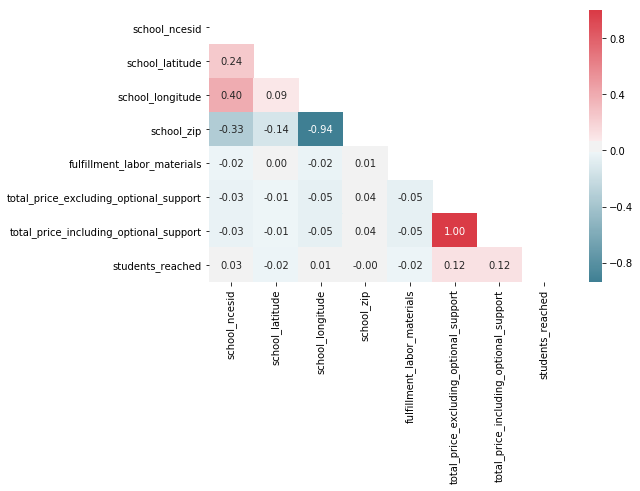

In [275]:
cont_feats = list(df.describe())
create_correlation_heatmap(df)

## 3. Pre-Process and Clean Data

#### Drop columns

In [276]:
df.columns

Index(['teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude',
       'school_longitude', 'school_city', 'school_state', 'school_zip',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp',
       'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded'],
      dtype='object')

In [277]:
df = df.drop(columns=['teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude',
                      'school_city', 'school_zip', 'school_district'])

#### Convert 'fully_funded' from t/f to 1/0

In [278]:
def convert_str_to_binary(binary_cols):
    for i in binary_cols:
        if df[i].dtype != 'int32':
            df[i] = np.where((df[i] == 't'), 1, 0)

In [279]:
binary_cols = ['school_county', 'school_charter', 'school_magnet', 'school_year_round',
               'school_nlns', 'school_kipp', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
               'eligible_double_your_impact_match', 'eligible_almost_home_match', 'fully_funded']

convert_str_to_binary(binary_cols)

#### Convert Categorical Features to Binary Features

In [280]:
def one_hot_encoding_categorical(df):
    # separate out categorical features
    cat_feats = [x for x in df.select_dtypes(include=['object']).columns]
    print(cat_feats)
    
    # one hot encoding for categorical features
    binary_feats = pd.get_dummies(df[cat_feats])

    # concatenate binary features
    df = pd.concat([df, binary_feats], axis=1)
    df = df.drop(cat_feats, axis=1)
    return df

In [281]:
df = one_hot_encoding_categorical(df)

['school_state', 'school_metro', 'school_charter_ready_promise', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']


#### Check for NAs

In [282]:
print('% of rows with missing values:', round(len(df[df.isnull().any(axis=1)])/len(df),5)*100)

% of rows with missing values: 0.029


In [283]:
print('Columns with missing values:', df.columns[df.isnull().any()].tolist())

Columns with missing values: ['students_reached']


#### Fill NAs

In [284]:
def fill_na_with_zero(df):
    df2 = df.copy(deep=True)
    null_vars = list(df2.columns[df2.isnull().any()])
    for i in null_vars:
        df2[i] = df2[i].fillna(0)
    return df2

In [285]:
df = fill_na_with_zero(df)

### Check Skew

In [286]:
numeric_columns = ['fulfillment_labor_materials', 'total_price_excluding_optional_support',
                   'total_price_including_optional_support', 'students_reached']

In [287]:
def histogram(df, column, bins, xmin, xmax, ymin, ymax):
    '''
    Create histogram of variable
    '''
    plt.figure(figsize=(9,5))
    n, bins, patches = plt.hist(df[column], bins=bins, alpha=0.75, color='grey')
    
    # plot histogram
    plt.xlabel(column)
    plt.ylabel('Probability')
    plt.title('Histogram of ' + column)
    plt.axis([xmin, xmax, ymin, ymax])
    plt.grid(True)
    plt.show()   

#### 'fulfillment_labor_materials'

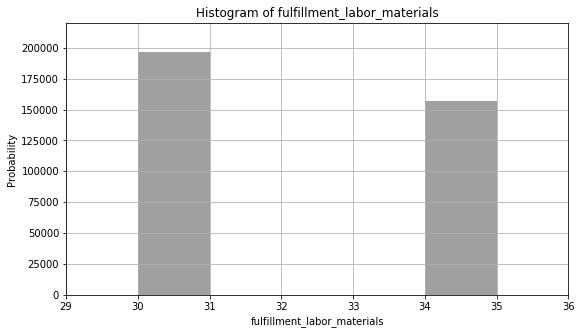

In [288]:
histogram(df, 'fulfillment_labor_materials', bins=5, xmin=29, xmax=36, ymin=0, ymax=220000)

#### 'total_price_excluding_optional_support'

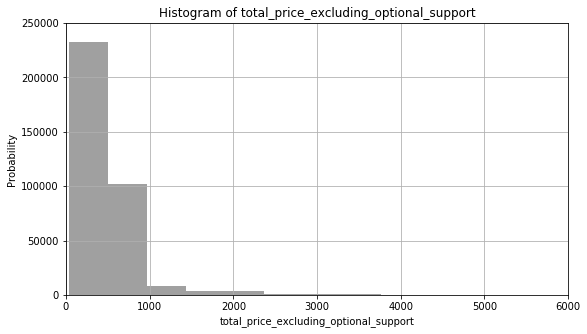

In [289]:
histogram(df, 'total_price_excluding_optional_support', bins=300, xmin=0, xmax=6000, ymin=0, ymax=250000)

This is clearly skewed, so let's try taking the log.

In [290]:
def log_histogram(df, column, bins, xmin, xmax, ymin, ymax):
    # fit the normal distribution on log target
    mu, sigma = norm.fit(np.log(df[column]))

    # create histogram of log column
    plt.figure(figsize=(7,5))
    n, bins, patches = plt.hist(np.log(df[column]), bins=bins, normed=True, alpha=0.75, color='Grey')

    # add fitted line
    y = mlab.normpdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'g--', linewidth=2)

    # plot histogram
    plt.xlabel('Log {}'.format(column))
    plt.ylabel('Probability')
    plt.title('Histogram of Log {}: mu = {}, sigma = {}'.format(column, round(mu, 2), round(sigma, 2)))
    plt.axis([xmin, xmax, ymin, ymax])
    plt.grid(True)
    plt.show()

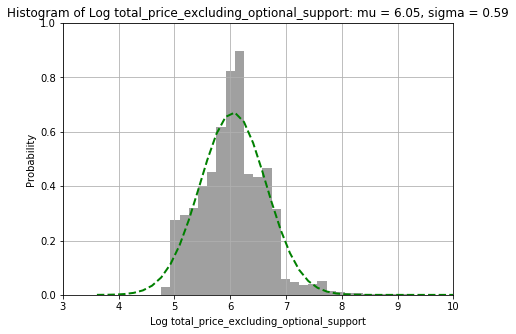

In [291]:
log_histogram(df, 'total_price_excluding_optional_support', bins=50, xmin=3, xmax=10, ymin=0, ymax=1)

In [292]:
def log_column(df, column):
    log_column = 'log_' + column
    df[log_column] = np.log(df[column])
    df = df.drop(columns=column)
    return df

In [293]:
df = log_column(df, 'total_price_excluding_optional_support')

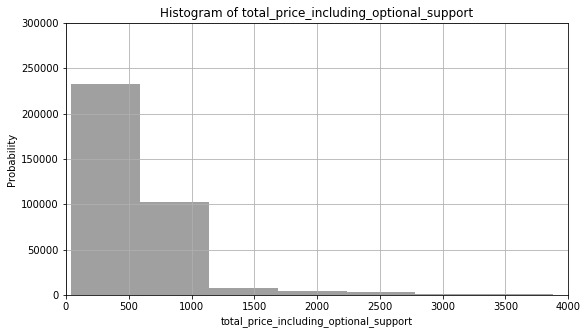

In [294]:
histogram(df, 'total_price_including_optional_support', bins=300, xmin=0, xmax=4000, ymin=0, ymax=300000)

This also looks skewed => log transform.

#### 'total_price_including_optional_support'

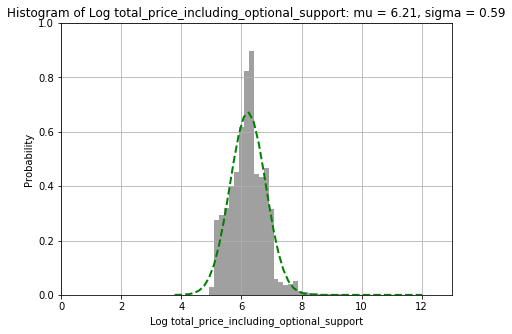

In [295]:
log_histogram(df, 'total_price_including_optional_support', bins=50, xmin=0, xmax=13, ymin=0, ymax=1)

In [296]:
df = log_column(df, 'total_price_including_optional_support')

#### 'students_reached'

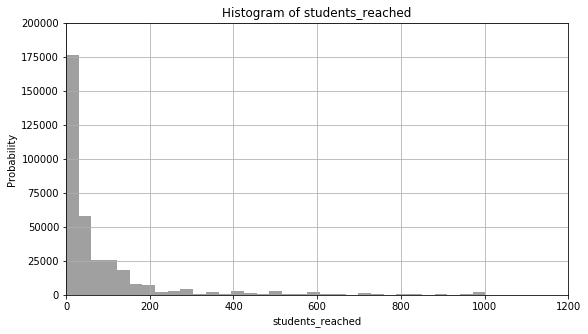

In [297]:
histogram(df, 'students_reached', bins=400, xmin=0, xmax=1200, ymin=0, ymax=200000)

In [298]:
# add one so that I can take the log of this column
df['students_reached'] += 1

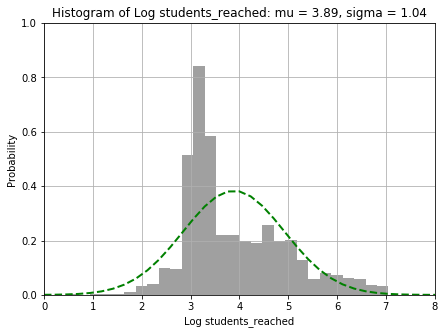

In [299]:
log_histogram(df, 'students_reached', bins=40, xmin=0, xmax=8, ymin=0, ymax=1)

This is not a perfect transformation, but it still looks better than the previous.

In [300]:
df = log_column(df, 'students_reached')

#### Outlier Detection

In [301]:
new_numeric_columns = ['fulfillment_labor_materials', 'log_total_price_excluding_optional_support',
                       'log_total_price_including_optional_support', 'log_students_reached']

In [302]:
def iqr_outlier(var):
    q1, q3 = np.percentile(var, [20, 80])
    iqr = q3 - q1
    lower_fence = q1 - (iqr * 1.5)
    upper_fence = q3 + (iqr * 1.5)
    print('Lower fence:', round(lower_fence, 2))
    print('Upper fence:', round(upper_fence, 2))
    outlier_array = np.where((var > upper_fence) | (var < lower_fence))
    print('Number of outliers:', len(outlier_array[0]))
    print('Percentage of outliers:', round(len(outlier_array[0])/len(df['log_total_price_excluding_optional_support']), 3))
    print('\n')
    return outlier_array

In [303]:
for i in new_numeric_columns:
    print('Variable:', i)
    iqr_outlier(df[i])

Variable: fulfillment_labor_materials
Lower fence: 22.5
Upper fence: 42.5
Number of outliers: 0
Percentage of outliers: 0.0


Variable: log_total_price_excluding_optional_support
Lower fence: 4.07
Upper fence: 8.0
Number of outliers: 2268
Percentage of outliers: 0.006


Variable: log_total_price_including_optional_support
Lower fence: 4.23
Upper fence: 8.16
Number of outliers: 2268
Percentage of outliers: 0.006


Variable: log_students_reached
Lower fence: 0.53
Upper fence: 7.35
Number of outliers: 109
Percentage of outliers: 0.0




Given that the percentage of outliers is up to 0.6%, I'm deciding to keep them in, since it's likely that I will encounter the same outliers in my test set.

### 4. Generate Features/Predictors

#### Convert Datetime Feature to Numeric Features

In [304]:
df['weekday'] = df['date_posted'].dt.dayofweek
df['week'] = df['date_posted'].dt.weekofyear
df['month'] = df['date_posted'].dt.month
df['quarter'] = df['date_posted'].dt.quarter

### 5. Create Temporal Train/Test Sets

In [317]:
def temporal_train_test_split(df, time_col, period=None):
    '''
    Creates temporal train/test splits.
    Inputs: 
        df
        time_col (str): name of time column
        period (str of the format '1M', '3M', '6M', etc.): how long the 
            testing period should be
    Returns:
        test_dfs: list of test dfs
        train_dfs: list of training dfs
        times: list of start times indexed to test and train lists
    '''
    time_starts = pd.date_range(start = df[time_col].min(), 
                                end = df[time_col].max(), freq = period)
    times = []
    train_sets = []
    test_sets = []

    for i, time in enumerate(time_starts[:-1]):
        time_split = time + pd.DateOffset(1)
        train_mask = (df[time_col] <= time)
        test_mask = (df[time_col] > time_split) & (df[time_col] < time_starts[i+1])
        
        train = df.loc[train_mask]
        train = train.drop(columns=time_col)
        test = df.loc[test_mask]
        test = test.drop(columns=time_col)

        train_sets.append(train)
        test_sets.append(test)
        times.append(time)
        
    return train_sets, test_sets, times

### 6. Model Loop Code
Adapted largely from: https://github.com/rayidghani/magicloops/blob/master/magicloops.py

In [318]:
def plot_precision_recall(y_true, y_prob, model_name):
    """Adapted from: https://github.com/rayidghani/magicloops/blob/master/magicloops.py"""
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)

    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)

    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    plt.title(model_name)
    plt.show()

In [319]:
def precision_at_k(y_true, y_scores, k):
    """Adapted from: https://github.com/rayidghani/magicloops/blob/master/magicloops.py"""
    idx = np.argsort(np.array(y_scores))[::-1]
    y_scores, y_true = np.array(y_scores)[idx], np.array(y_true)[idx]
    cutoff_index = int(len(y_scores) * (k / 100.0))
    preds_at_k = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    precision = precision_score(y_true, preds_at_k)
    return precision

In [320]:
def clfs_loop(models, clfs, grid, X_train, X_test, y_train, y_test, plot=True):
    """
    Adapted from: https://github.com/rayidghani/magicloops/blob/master/magicloops.py
    Runs each model in models and calculates the AUC-ROC score, 
    calculates precision at 1%, 5%, 10%, 20%, 30%, and 50%,
    and plots the precision-recall curve.
    Inputs:
        models: list of models
        clfs: list of parameters
        grid
        X
        y
        plot
    Returns: results_df: a DataFrame of results
    """
    results_df =  pd.DataFrame(columns=('model_type', 'clf', 'parameters', 'auc-roc',
                                        'p_at_1', 'p_at_2', 'p_at_5',
                                        'p_at_10', 'p_at_20', 'p_at_30', 'p_at_50'))
        
    for i, clf in enumerate([clfs[m] for m in models]):
        print(models[i])
        params = grid[models[i]]
        for p in ParameterGrid(params):
            try:
                clf.set_params(**p)
                y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                results_df.loc[len(results_df)] = [models[i], clf, p,
                                                   roc_auc_score(y_test, y_pred_probs),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,2.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]
                if plot:
                    plot_precision_recall(y_test, y_pred_probs, clf)
        
            except IndexError as e:
                print('Error:', e)
                continue
    return results_df

## 8. Evaluate Models

In [321]:
def clfs_loop_temporal(train_sets, test_sets, target, models, clfs):
    all_results = []
    
    for i in range(len(train_sets)):
        train = train_sets[i]
        test = test_sets[i]

        y_train = train[target]
        X_train = train.drop(columns=target)
        y_test = test[target]
        X_test = test.drop(columns=target)

        results = clfs_loop(models, clfs, grid, X_train, X_test, y_train, y_test)
        all_results.append(results)

In [322]:
clfs = {'LR': LogisticRegression(), 
        'KNN': KNeighborsClassifier(),
        'DT': DecisionTreeClassifier(), 
        'RF': RandomForestClassifier(), 
        'AB': AdaBoostClassifier(),
        'BAG': BaggingClassifier()}
    
grid = {'LR': { 'penalty': ['l1','l2'], 'C': [0.01,0.1,1,10]},
        'KNN' :{'n_neighbors': [1,5,10,25,50,100], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto','ball_tree','kd_tree']},
        'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50], 'min_samples_split': [5,25]},
        'RF':{'n_estimators': [10,100], 'max_depth': [5,25], 'max_features': ['sqrt','log2'], 
              'min_samples_split': [5,10], 'n_jobs': [-1]},
        'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100]},
        'BAG': {'n_estimators': [10,100]}}

In [323]:
train_sets, test_sets, times = temporal_train_test_split(df, 'date_posted', period='12M')

LR


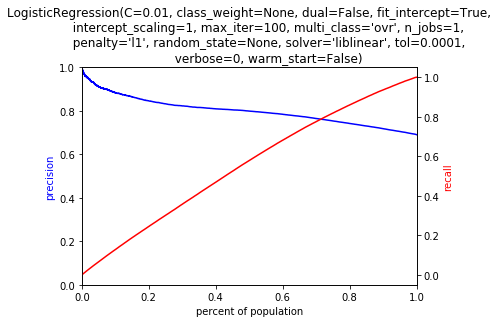

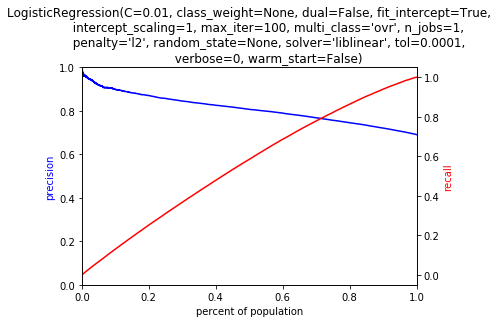

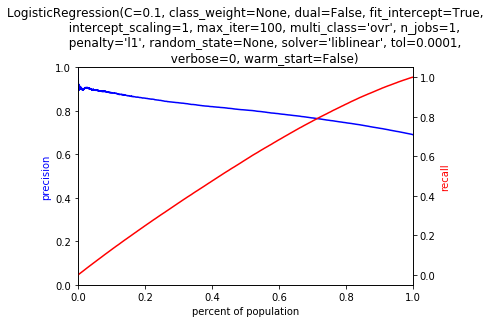

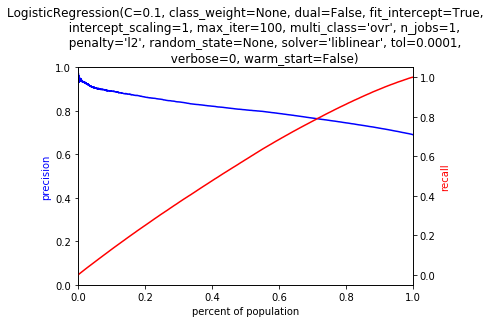

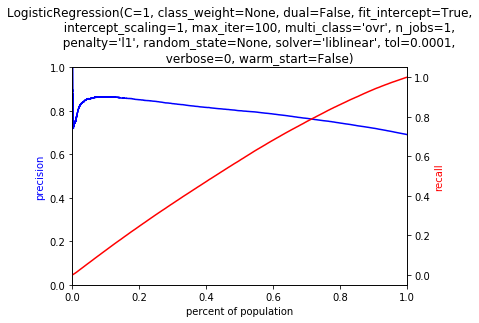

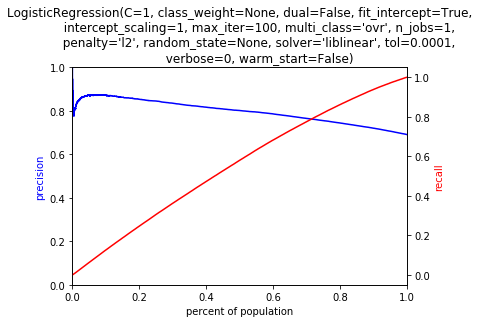

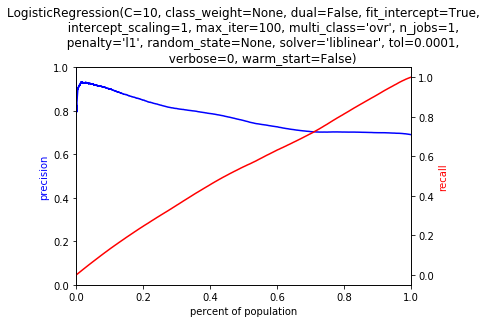

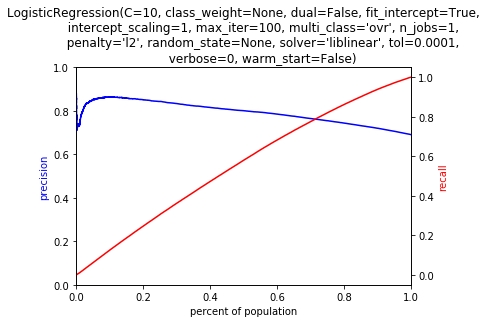

KNN


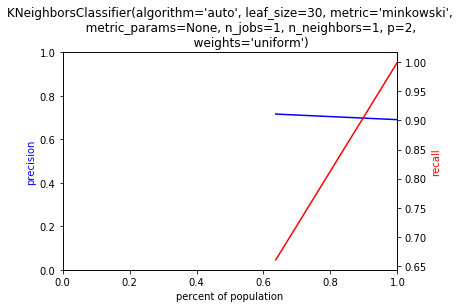

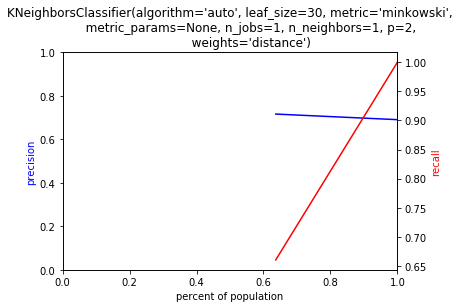

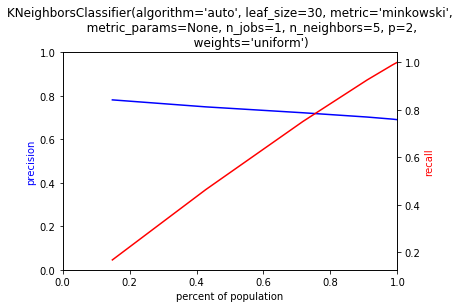

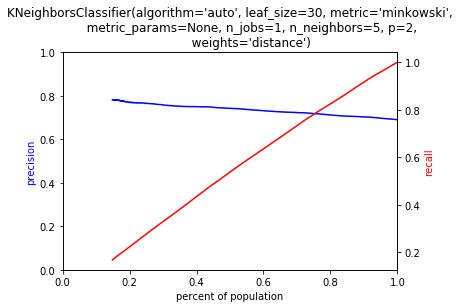

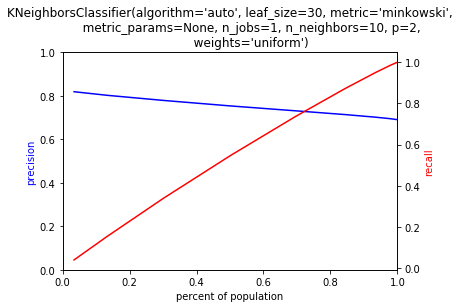

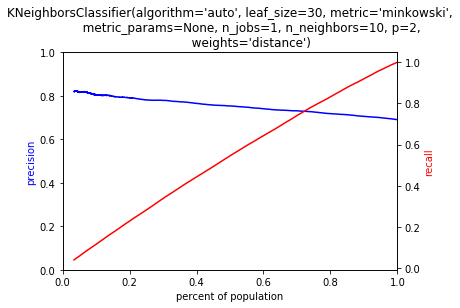

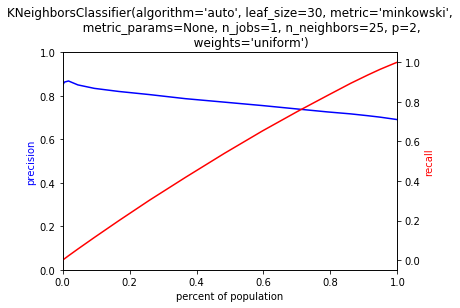

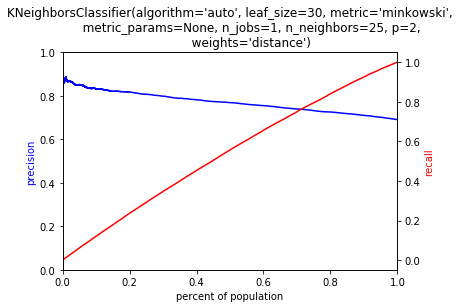

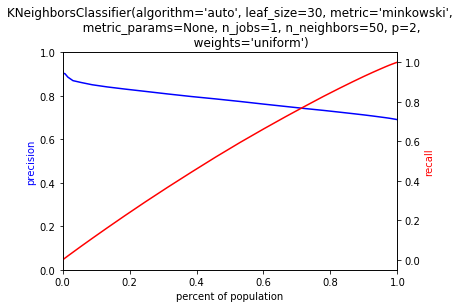

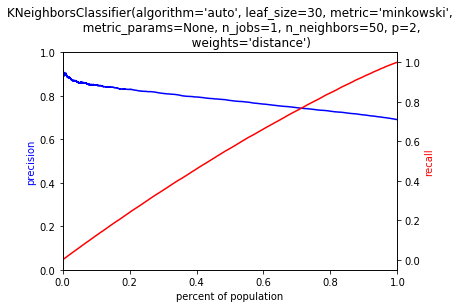

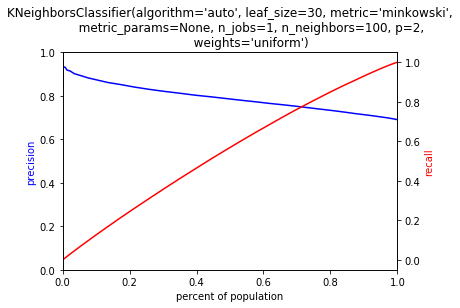

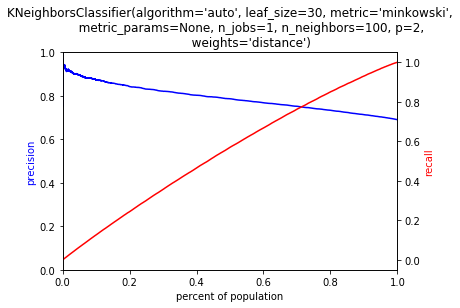

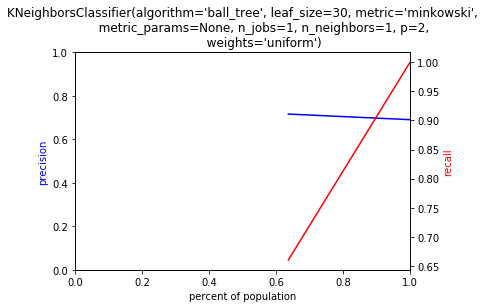

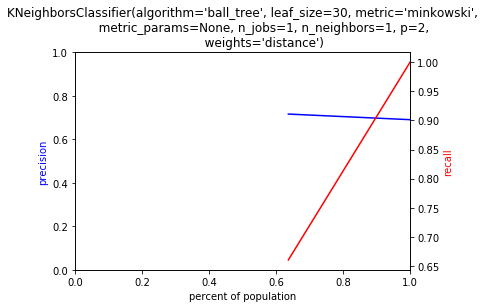

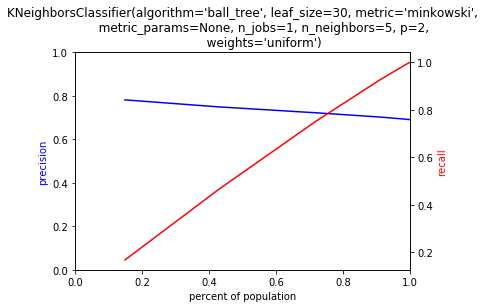

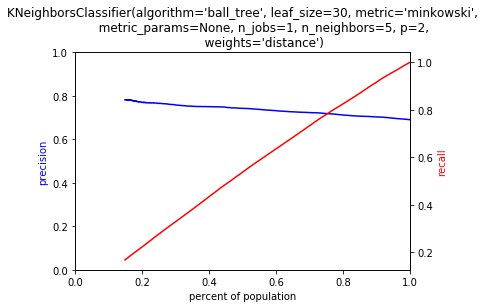

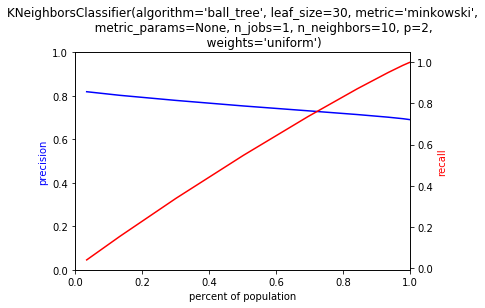

KeyboardInterrupt: 

In [326]:
models = ['LR', 'KNN', 'DT', 'RF', 'AB', 'BAG']
results_df = clfs_loop_temporal(train_sets, test_sets, 'fully_funded', models, clfs)